In [87]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [88]:
data = pd.read_csv('Final.csv')

In [89]:
data_list = data.values.tolist()

In [90]:
item_list = []

for i in data_list:
    item_list.append(list(map(str,i)))

In [91]:
data = data.astype(float)

In [92]:
data = data.applymap(str)

# Word2Vec

In [93]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

In [94]:
path = get_tmpfile('word2vec.model')

In [95]:
model = Word2Vec(item_list, size=1 ,window=5, min_count=1,workers=5)
model.save('word2vec.model')

In [96]:
model = Word2Vec.load('word2vec.model')

In [97]:
word_vectors = model.wv  
vocabs = word_vectors.vocab.keys() #vocabs has keys that is item number

#word_vectors_list has values that is vector value from item number
word_vectors_list = [word_vectors[v] for v in vocabs] 

In [98]:
for i in range(len(data)):            #word2vec value를 data로 넣음
    for j in range(len(data.iloc[i])):
        key=str(data.iloc[i,j])
        data.iloc[i,j] = word_vectors[key].tolist()[0]

In [99]:
data = data.apply(pd.to_numeric)

# Data split && Learning

In [100]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from heapq import nsmallest
import time

In [101]:
X_data = data.drop('13',axis=1)
y_data = data['13']

# Result

In [102]:
seed = 6
test_size = 0.2
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=test_size, random_state=seed)
model = xgb.XGBClassifier(n_estimators=1000,max_depth=8,learning_rate=0.1,subsample=0.5)
time1 = time.time()
model.fit(X_train,y_train)
time2 = time.time()
print(time2-time1)

781.923483133316


In [17]:
avg_time = []
avg_acu = []

for i in range(10):
    print(i+1, "번째 추천 시작")
    
    result = pd.DataFrame()
    start = time.time()
    seed = i
    X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=test_size, random_state=seed)
    prediction = model.predict(X_test)
    end = time.time()
    print(i+1, "번째 추천(2000건)에 걸린 시간(초):", end-start)
    print(i+1, "번째 데이터 한개당 걸린 시간 :", (end-start)/2000)
    
    result['predicted'] = prediction
    result['Y_test'] = y_test.tolist()
    
    #예측값과 근사한 값 5개 출력
    vector_list = []

    for i in range(len(result)):
        vector_list.append(nsmallest(6, word_vectors_list, key=lambda x: abs(x-result['predicted'].iloc[i])))
    
    result['Nearby5'] = pd.Series(vector_list)
    
    for i in range(len(result)):
        result['Nearby5'].iloc[i] = vector_list[i]
    
    T_F = []
    for i in range(len(result)):
        if result['Y_test'].iloc[i] in result['Nearby5'].iloc[i]:
            T_F.append('True')
        else:
            T_F.append('False')
    
    result['T_F'] = T_F
    
    print("예측한 값과 가까운 아이템 5개의 Accuracy :", len(result[result['T_F']=='True'])/len(result))
    
    
    avg_acu.append(len(result[result['T_F']=='True'])/len(result))

    
    avg_time.append((end - start)/2000)
    print("----------------------------------------------------")
    
print("추천 정확도의 평균 :", sum(avg_acu)/len(avg_acu))
print("데이터 한개당 걸린 시간의 평균 :", sum(avg_time)/len(avg_time))

1 번째 추천 시작
1 번째 추천(2000건)에 걸린 시간(초): 125.40708565711975
1 번째 데이터 한개당 걸린 시간 : 0.06270354282855987
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9475
----------------------------------------------------
2 번째 추천 시작
2 번째 추천(2000건)에 걸린 시간(초): 127.96811175346375
2 번째 데이터 한개당 걸린 시간 : 0.06398405587673187
예측한 값과 가까운 아이템 5개의 Accuracy : 0.937
----------------------------------------------------
3 번째 추천 시작
3 번째 추천(2000건)에 걸린 시간(초): 132.65303230285645
3 번째 데이터 한개당 걸린 시간 : 0.06632651615142822
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9345
----------------------------------------------------
4 번째 추천 시작
4 번째 추천(2000건)에 걸린 시간(초): 130.75527691841125
4 번째 데이터 한개당 걸린 시간 : 0.06537763845920563
예측한 값과 가까운 아이템 5개의 Accuracy : 0.9445
----------------------------------------------------
5 번째 추천 시작
5 번째 추천(2000건)에 걸린 시간(초): 127.99315333366394
5 번째 데이터 한개당 걸린 시간 : 0.06399657666683196
예측한 값과 가까운 아이템 5개의 Accuracy : 0.935
----------------------------------------------------
6 번째 추천 시작
6 번째 추천(2000건)에 걸린 시간(초): 128.62337493896484
6 번째 데이터 한개

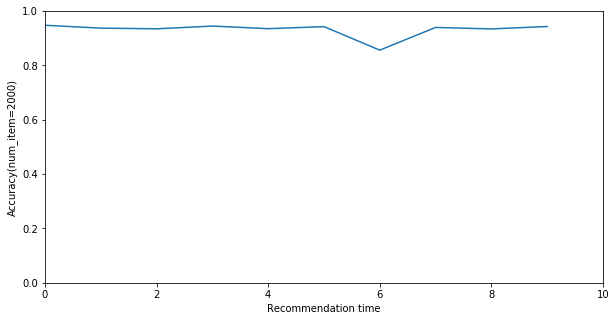

In [33]:
import matplotlib.pyplot as plt

plt.plot(avg_acu)
plt.xlabel("Recommendation time")
plt.ylabel("Accuracy(num_item=2000)")
plt.xlim(0,10)
plt.ylim(0,1)
plt.rcParams["figure.figsize"] = 10, 6
plt.show()

In [2]:
ap = [1, 2, 3]

In [8]:
ap[0] = 0

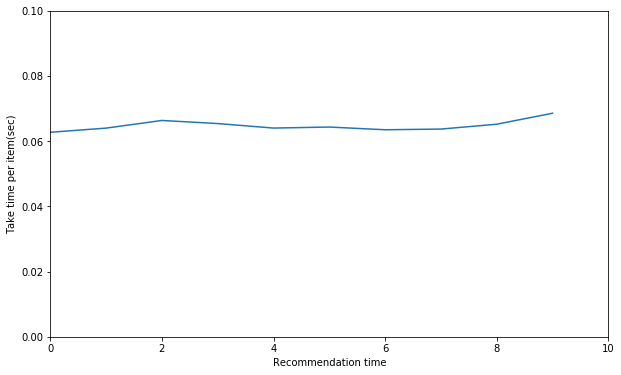

In [34]:
import matplotlib.pyplot as plt

plt.plot(avg_time)
plt.xlabel("Recommendation time")
plt.ylabel("Take time per item(sec)")
plt.xlim(0,10)
plt.ylim(0,0.1)
plt.rcParams["figure.figsize"] = 10, 6
plt.show()